In [1]:
# General
import pandas as pd
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns

# EDA
from pandas_profiling import ProfileReport

# With missforest we can use random forest to impute data. This is better than mean by far
# to avoid errors on loading missingpy
import sys
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import metrics

# Model to apply
import lightgbm as lgb # need to set manually what variables are categorical

# load stored data from data_imputation
%store -r train_final
%store -r test_final
train_df = train_final.copy()
test_df = test_final.copy()


Bad key figure.labelsize in file /Users/hectorcozar/Documents/GitHub/templates/venv/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/classic 2.mplstyle, line 310 ('figure.labelsize:   medium    # size of the figure label')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key figure.labelweight in file /Users/hectorcozar/Documents/GitHub/templates/venv/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/classic 2.mplstyle, line 311 ('figure.labelweight: normal    # weight of the figure label')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution


## Training & validation with lightgbm

In [2]:
# getting ready x and y variables
x = train_df.drop(['Id','SalePrice'],axis=1)
y = train_df.SalePrice

# train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 42)

In [3]:
# build the lightgbm model

val_model = lgb.LGBMRegressor(learning_rate = 0.09, max_depth = 5, random_state = 1) # lgb.LGBMClassifier() or LGBMRanker()
val_model.fit(x_train,y_train,eval_set=[(x_train,y_train), (x_test,y_test)],
          eval_metric='rmse')

[1]	training's rmse: 70732.7	training's l2: 5.00312e+09	valid_1's rmse: 80124.8	valid_1's l2: 6.41998e+09
[2]	training's rmse: 65876.6	training's l2: 4.33972e+09	valid_1's rmse: 75231.2	valid_1's l2: 5.65973e+09
[3]	training's rmse: 61518.6	training's l2: 3.78454e+09	valid_1's rmse: 70915.1	valid_1's l2: 5.02895e+09
[4]	training's rmse: 57462.7	training's l2: 3.30196e+09	valid_1's rmse: 66982	valid_1's l2: 4.48659e+09
[5]	training's rmse: 53821.9	training's l2: 2.89679e+09	valid_1's rmse: 63680.9	valid_1's l2: 4.05526e+09
[6]	training's rmse: 50644.8	training's l2: 2.5649e+09	valid_1's rmse: 60574.3	valid_1's l2: 3.66925e+09
[7]	training's rmse: 47804.1	training's l2: 2.28524e+09	valid_1's rmse: 57697.5	valid_1's l2: 3.329e+09
[8]	training's rmse: 45049.6	training's l2: 2.02947e+09	valid_1's rmse: 54990.3	valid_1's l2: 3.02394e+09
[9]	training's rmse: 42658.7	training's l2: 1.81977e+09	valid_1's rmse: 52656.4	valid_1's l2: 2.77269e+09
[10]	training's rmse: 40378.7	training's l2: 1.6304

LGBMRegressor(learning_rate=0.09, max_depth=5, random_state=1)

In [4]:
print('Training accuracy {:.4f}'.format(val_model.score(x_train,y_train)))
print('Testing accuracy {:.4f}'.format(val_model.score(x_test,y_test)))

Training accuracy 0.9620
Testing accuracy 0.8620


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

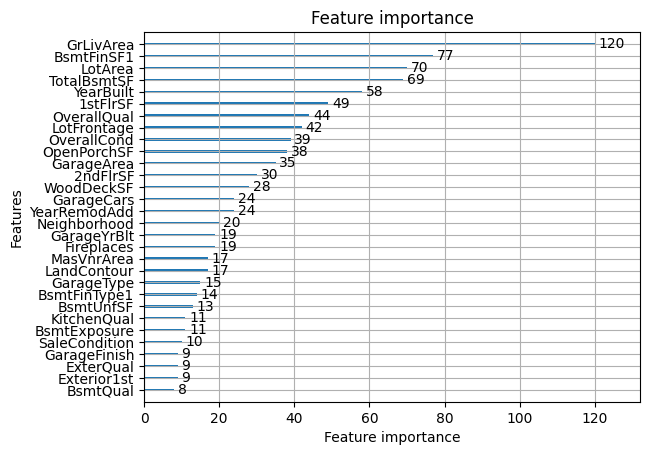

In [5]:
lgb.plot_importance(val_model, max_num_features = 30)


/Users/hectorcozar/Documents/GitHub/templates/venv/lib/python3.9/site-packages/lightgbm/plotting.py:372: UserWarning: More than one metric available, picking one to plot.
  _log_warning("More than one metric available, picking one to plot.")


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='l2'>

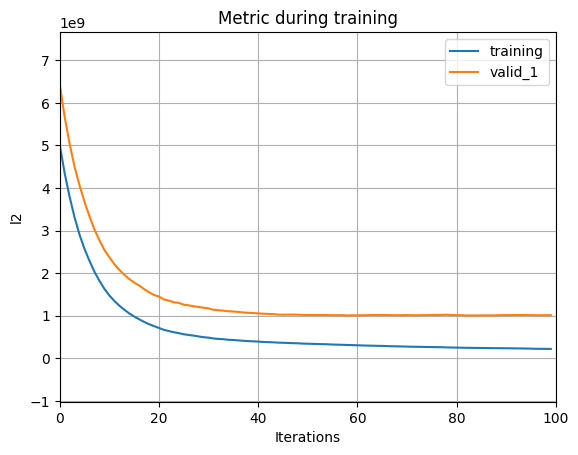

In [6]:
lgb.plot_metric(val_model)


## Submission with the validation model.

In [7]:
# making predictions
val_predictions = pd.DataFrame(val_model.predict(test_df.drop('Id', axis = 1)))

#merging predictions with the full data set
val_submission = pd.merge(test_df['Id'].astype(int),
                          val_predictions,
                          left_index = True,
                          right_index = True)
val_submission.rename(columns = {0: 'SalePrice'}, inplace = True)

# save to csv
val_submission.to_csv('../csv_data/val_submission_lightgbm.csv',
                  header = True, index = False)

## Full model submission

Once we have validated the model splitting train and test we are going to train the final model with all the train data we have. 

In [8]:
#training model with the whole dataset
model = lgb.LGBMRegressor(learning_rate = 0.09, max_depth = 5, random_state = 1) # lgb.LGBMClassifier() or LGBMRanker()
model.fit(x, y, eval_metric='rmse')

# making predictions
predictions = pd.DataFrame(model.predict(test_df.drop('Id', axis = 1)))


In [9]:
#merging predictions with the full data set
submission = pd.merge(test_df['Id'].astype(int),
                          predictions,
                          left_index = True,
                          right_index = True)
submission.rename(columns = {0: 'SalePrice'}, inplace = True)

In [10]:
# save to csv
submission.to_csv('../csv_data/submission_lightgbm.csv',
                  header = True, index = False)

In [ ]:
# # graphic to classification problems
# lgb.plot_tree(model,figsize=(30,40))


In [ ]:
# # graphic to classification problems
# metrics.plot_confusion_matrix(model,x_test,y_test,cmap='Blues_r')


In [ ]:
# # graphic to classification problems
# print(metrics.classification_report(y_test,model.predict(x_test)))
